#**Mini-Project 1: Modern Low Footprint Cyber Attack Detection** 


# **Model: Neural Network for Binary Classification- Feature Selection**


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
%cd "/content/drive/My Drive/P1_Final/"
!pip install import-ipynb
import import_ipynb
import warnings
warnings.filterwarnings('ignore')
# importing helper functions for data preprocessing and model visualization
import plotlib_helper as graphplot
import datapreprocess_helper as dataprep

/content/drive/My Drive/P1_Final


In [22]:
import pandas as pd
import io
import requests
import os
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
path = "/content/drive/My Drive/P1_Final/"

train_read = os.path.join(path,"data/P1_Supervised_preprocess_TRAINSET.csv")
test_read = os.path.join(path,"data/P1_Supervised_preprocess_TESTSET.csv")
df_train = pd.read_csv(train_read)
df_test= pd.read_csv(test_read)

In [23]:
df_train.shape

(81173, 66)

## **Data Preprocessing**
*   Converted input feature and target into numpy array for TensorFlow and feature selection








In [24]:
import re
y_train_fs=df_train.label
y_train_fs_num=y_train_fs.to_numpy()
x_train_fs=df_train.drop('label', axis=1)	  

x_train_fs_num=x_train_fs.to_numpy()
print(x_train_fs_num.shape)

(81173, 65)


In [25]:
y_test_fs=df_test.label
y_test_fs_num=y_test_fs.to_numpy()
x_test_fs=df_test.drop('label', axis=1)

x_test_fs_num=x_test_fs.to_numpy()
print(x_test_fs_num.shape)

(35179, 65)


Encode output


In [26]:
attack = dataprep.encode_text_index(df_train,'label')
print(attack)

[0 1]


## **Feature selection**

In [27]:
from sklearn.feature_selection import SelectKBest, f_classif

# SelectKBest to perform feature selection to retrieve 10 best features 
fvalue_selector = SelectKBest(f_classif, k=10)

# Apply the SelectKBest object to the features and target
x_train_best = fvalue_selector.fit_transform(x_train_fs_num, y_train_fs_num)
x_test_best=fvalue_selector.fit_transform(x_test_fs_num, y_test_fs_num)

###**Top 10 best feature selection**


In [28]:
import pandas as pd

print('Total features in original train set',x_train_fs.shape[1])
print('Features after performing SelectKBest', x_train_best.shape[1])
print('Top 10 feature columns: ')
x_train_fs.columns[fvalue_selector.get_support(indices=True)].tolist()

Total features in original train set 65
Features after performing SelectKBest 10
Top 10 feature columns: 


['sttl',
 'ct_srv_src',
 'ct_state_ttl',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'ct_srv_dst',
 'state-CON',
 'state-INT',
 'attack_cat-Generic',
 'attack_cat-Normal']

###**Scores computed for each feature using SelectKBest**

In [29]:
selected_features_df = pd.DataFrame({'Feature':list(x_train_fs.columns),'Scores':fvalue_selector.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)

,Feature,Scores
62,attack_cat-Normal,inf
28,ct_state_ttl,6.752095e+04
6,sttl,4.151726e+04
61,attack_cat-Generic,2.504474e+04
43,state-INT,2.384177e+04
...,...,...
10,sloss,3.331854e+00
44,state-REQ,2.260322e+00
50,service-irc,1.883528e+00
52,service-radius,1.195641e-01


In [30]:
topFeatures=selected_features_df.nlargest(10,'Scores')
topFeatures=topFeatures.sort_values(by='Scores', ascending=False)
print(topFeatures)

               Feature        Scores
62   attack_cat-Normal           inf
28        ct_state_ttl  6.752095e+04
6                 sttl  4.151726e+04
61  attack_cat-Generic  2.504474e+04
43           state-INT  2.384177e+04
41           state-CON  1.125093e+04
27          ct_srv_src  9.046051e+03
37          ct_srv_dst  8.985007e+03
31    ct_dst_sport_ltm  7.660008e+03
32      ct_dst_src_ltm  7.103948e+03


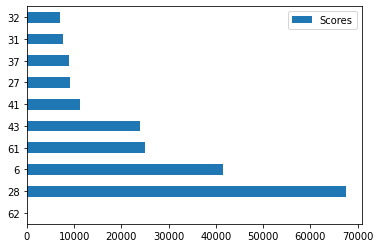

In [31]:
import matplotlib.pyplot as plt
topFeatures.nlargest(10,'Scores').plot(kind='barh')
plt.show()

##**Conversion into Numpy arrays for Neural Network**

In [32]:
# converting x, y numpy arrays for TensorFlow 
x_train, y_train = dataprep.to_xy(df_train, 'label')
x_test, y_test = dataprep.to_xy(df_test, 'label')
print(f"Training set shape x:{x_train.shape} y:{y_train.shape}")
print(f"Testing set shape x:{x_test.shape} y:{y_test.shape}")
y_train

Training set shape x:(81173, 65) y:(81173, 2)
Testing set shape x:(35179, 65) y:(35179, 2)


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

##**Model Creation and Training - Original All-feature Dataset**

In [33]:
from datetime import datetime
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

path="/content/drive/My Drive/Project_1/"
filepath_savemodel = os.path.join(path,"dnn/proj1_neuralnetsAdd.hdf5")
# checkpoint to save the best weights 
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True) # save best model

start_time = datetime.now() 
for i in range(5):
    neuralnets_model = Sequential()
    neuralnets_model.add(Dense(20, input_dim=x_train.shape[1], activation='relu'))
    neuralnets_model.add(Dense(10, activation='relu'))
    neuralnets_model.add(Dense(y_train.shape[1], activation='softmax'))
    neuralnets_model.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')

    neuralnets_model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpoint],verbose=2,epochs=100)

time_elapsed_Original = datetime.now() - start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed_Original))
neuralnets_model.load_weights(filepath_savemodel) # load weights from best model


Epoch 1/100
2537/2537 - 3s - loss: 0.0183 - val_loss: 0.0051
Epoch 2/100
2537/2537 - 3s - loss: 8.8739e-04 - val_loss: 0.0022
Epoch 3/100
2537/2537 - 3s - loss: 7.6726e-04 - val_loss: 0.0018
Epoch 4/100
2537/2537 - 3s - loss: 4.6085e-04 - val_loss: 0.0012
Epoch 5/100
2537/2537 - 3s - loss: 2.3505e-04 - val_loss: 2.5625e-04
Epoch 6/100
2537/2537 - 3s - loss: 1.0945e-04 - val_loss: 8.4977e-04
Epoch 7/100
2537/2537 - 3s - loss: 2.3981e-06 - val_loss: 7.8782e-04
Epoch 00007: early stopping
Epoch 1/100
2537/2537 - 3s - loss: 0.0382 - val_loss: 0.0014
Epoch 2/100
2537/2537 - 3s - loss: 3.0650e-04 - val_loss: 0.0044
Epoch 3/100
2537/2537 - 3s - loss: 8.0122e-04 - val_loss: 0.0033
Epoch 4/100
2537/2537 - 3s - loss: 7.2897e-05 - val_loss: 4.1762e-04
Epoch 00004: early stopping
Epoch 1/100
2537/2537 - 3s - loss: 0.0229 - val_loss: 0.0036
Epoch 2/100
2537/2537 - 3s - loss: 6.4585e-04 - val_loss: 8.9113e-04
Epoch 3/100
2537/2537 - 3s - loss: 9.4244e-04 - val_loss: 0.0057
Epoch 4/100
2537/2537 - 3s

##**Model Performance Evaluation- Original All-feature Dataset**

Performance Metrics using all-feature dataset
---------------------------------------
Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


[[ 9625     0]
 [    0 25554]]


Plotting confusion matrix


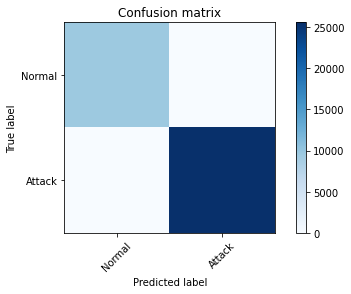



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9625
           1       1.00      1.00      1.00     25554

    accuracy                           1.00     35179
   macro avg       1.00      1.00      1.00     35179
weighted avg       1.00      1.00      1.00     35179




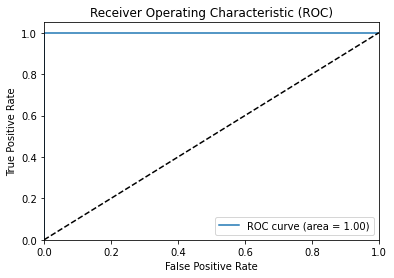

In [34]:
pred = neuralnets_model.predict(x_test)
pred = np.argmax(pred,axis=1)
graphplot.performance_metrics(pred, y_test, ["Normal", "Attack"], "Performance Metrics using all-feature dataset")

##**Model Creation and Training- Selected Top-10 Best features**

In [35]:
# converting x, y numpy arrays for TensorFlow 
x_train, y_train = dataprep.to_xy(df_train, 'label')
x_test, y_test = dataprep.to_xy(df_test, 'label')
print(f"Training set shape x:{x_train.shape} y:{y_train.shape}")
print(f"Testing set shape x:{x_test.shape} y:{y_test.shape}")
y_train

Training set shape x:(81173, 65) y:(81173, 2)
Testing set shape x:(35179, 65) y:(35179, 2)


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [36]:
x_train_best.shape

(81173, 10)

In [37]:
from datetime import datetime
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

path="/content/drive/My Drive/Project_1/"
filepath_savemodel = os.path.join(path,"dnn/proj1_neuralnetsAddF.hdf5")
# checkpoint to save the best weights 
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True) # save best model

start_time = datetime.now() 
for i in range(5):
    neuralnets_model = Sequential()
    neuralnets_model.add(Dense(20, input_dim=x_train_best.shape[1], activation='relu'))
    neuralnets_model.add(Dense(10, activation='relu'))
    neuralnets_model.add(Dense(y_train.shape[1], activation='softmax'))
    neuralnets_model.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')

    neuralnets_model.fit(x_train_best,y_train,validation_data=(x_test_best,y_test),callbacks=[monitor,checkpoint],verbose=2,epochs=100)

time_elapsed_feature = datetime.now() - start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed_feature))
neuralnets_model.load_weights(filepath_savemodel) # load weights from best model


Epoch 1/100
2537/2537 - 3s - loss: 0.0226 - val_loss: 5.4945e-04
Epoch 2/100
2537/2537 - 3s - loss: 1.2477e-04 - val_loss: 5.5081e-05
Epoch 3/100
2537/2537 - 3s - loss: 1.2207e-05 - val_loss: 1.4266e-05
Epoch 4/100
2537/2537 - 3s - loss: 2.7052e-06 - val_loss: 5.0282e-06
Epoch 00004: early stopping
Epoch 1/100
2537/2537 - 3s - loss: 0.0230 - val_loss: 1.5878e-04
Epoch 2/100
2537/2537 - 3s - loss: 4.5712e-05 - val_loss: 2.6019e-05
Epoch 3/100
2537/2537 - 3s - loss: 8.0401e-06 - val_loss: 5.8801e-06
Epoch 4/100
2537/2537 - 3s - loss: 1.7871e-06 - val_loss: 1.6385e-06
Epoch 00004: early stopping
Epoch 1/100
2537/2537 - 3s - loss: 0.0228 - val_loss: 2.8079e-04
Epoch 2/100
2537/2537 - 3s - loss: 5.2104e-05 - val_loss: 7.0014e-05
Epoch 3/100
2537/2537 - 3s - loss: 8.2128e-06 - val_loss: 3.4344e-05
Epoch 4/100
2537/2537 - 3s - loss: 1.8232e-06 - val_loss: 1.9771e-05
Epoch 00004: early stopping
Epoch 1/100
2537/2537 - 3s - loss: 0.0398 - val_loss: 4.7037e-04
Epoch 2/100
2537/2537 - 3s - loss: 

## Model Performance Evaluation- Selected Top-10 Best Features

Performance Metrics using Selected Top-10 best features
---------------------------------------
Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


[[ 9625     0]
 [    0 25554]]


Plotting confusion matrix


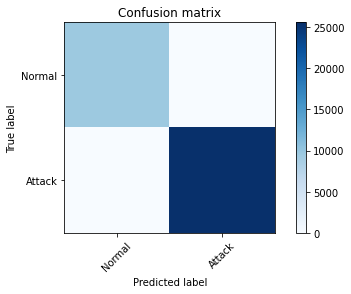



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9625
           1       1.00      1.00      1.00     25554

    accuracy                           1.00     35179
   macro avg       1.00      1.00      1.00     35179
weighted avg       1.00      1.00      1.00     35179




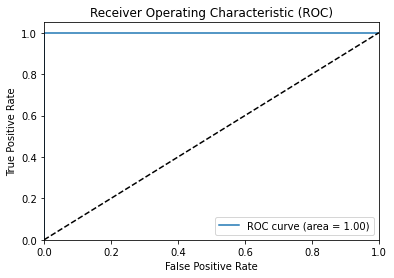

In [38]:
pred = neuralnets_model.predict(x_test_best)
pred = np.argmax(pred,axis=1)
graphplot.performance_metrics(pred, y_test, ["Normal", "Attack"], "Performance Metrics using Selected Top-10 best features")

##**Comparision of model training time with and without feature selection**

In [39]:
print("Model training time using Original All-feature Dataset:", time_elapsed_Original)
print("Model training time using Selected Top-10 Best Dataset:", time_elapsed_feature)

Model training time using Original All-feature Dataset: 0:01:21.497597
Model training time using Selected Top-10 Best Dataset: 0:00:54.392639
